In [1]:
import json
import glob
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from sklearn.metrics import average_precision_score

In [2]:
os.chdir('/home/walml/repos/morphology-tools/anomaly')
import shared

In [17]:
gz2_gp_search = '/home/walml/repos/morphology-tools/anomaly/results/gz2/predictions_gp_cnn_cnn_odd_kagglev3_*.json'
gz2_gp_records = [json.load(open(loc, 'r')) for loc in glob.glob(gz2_gp_search)]
assert gz2_gp_records

gz2_forest_search = '/home/walml/repos/morphology-tools/anomaly/results/gz2/predictions_forest_ellipse_kaggle_ellipse_odd_*.json'
gz2_forest_records = [json.load(open(loc, 'r')) for loc in glob.glob(gz2_forest_search)]
assert gz2_forest_records

In [19]:
decals_mergers_gp_search = '/home/walml/repos/morphology-tools/anomaly/results/decals/predictions_gp_cnn_cnn_mergers_final_*.json'
decals_mergers_gp_records = [json.load(open(loc, 'r')) for loc in glob.glob(decals_mergers_gp_search)]
assert decals_mergers_gp_records

decals_ring_responses_gp_search = '/home/walml/repos/morphology-tools/anomaly/results/decals/predictions_gp_cnn_cnn_ring_responses_nofilter_final_*.json'
decals_ring_responses_gp_records = [json.load(open(loc, 'r')) for loc in glob.glob(decals_ring_responses_gp_search)]
assert decals_ring_responses_gp_records

decals_irreg_gp_search = '/home/walml/repos/morphology-tools/anomaly/results/decals/predictions_gp_cnn_cnn_irregular_nofilter_final_*.json'
decals_irreg_gp_records = [json.load(open(loc, 'r')) for loc in glob.glob(decals_irreg_gp_search)]
assert decals_irreg_gp_records



decals_mergers_forest_search = '/home/walml/repos/morphology-tools/anomaly/results/decals/predictions_forest_ellipse_ellipse_mergers_nofilter_final_*.json'
decals_mergers_forest_records = [json.load(open(loc, 'r')) for loc in glob.glob(decals_mergers_forest_search)]
assert decals_mergers_forest_records

decals_ring_responses_forest_search = '/home/walml/repos/morphology-tools/anomaly/results/decals/predictions_forest_ellipse_ellipse_ring_responses_nofilter_final_*.json'
decals_ring_responses_forest_records = [json.load(open(loc, 'r')) for loc in glob.glob(decals_ring_responses_forest_search)]
assert decals_ring_responses_forest_records

decals_irreg_forest_search = '/home/walml/repos/morphology-tools/anomaly/results/decals/predictions_forest_ellipse_ellipse_irregular_nofilter_final_*.json'
decals_irreg_forest_records = [json.load(open(loc, 'r')) for loc in glob.glob(decals_irreg_forest_search)]
assert decals_irreg_forest_records


In [26]:
all_gp_records = [gz2_gp_records, decals_mergers_gp_records,decals_ring_responses_gp_records, decals_irreg_gp_records]
all_forest_records = [gz2_forest_records, decals_mergers_forest_records, decals_ring_responses_forest_records, decals_irreg_forest_records]

In [27]:

for record in gz2_gp_records:
    for key, value in record.items():
        record[key] = np.array(value)

for record in gz2_forest_records:
    for key, value in record.items():
        record[key] = np.array(value)

        
        
for record in decals_mergers_gp_records:
    for key, value in record.items():
        record[key] = np.array(value)

for record in decals_ring_responses_gp_records:
    for key, value in record.items():
        record[key] = np.array(value)

        
        
for record in decals_irreg_gp_records:
    for key, value in record.items():
        record[key] = np.array(value)

for record in decals_mergers_forest_records:
    for key, value in record.items():
        record[key] = np.array(value)

        
        
for record in decals_ring_responses_forest_records:
    for key, value in record.items():
        record[key] = np.array(value)

for record in decals_irreg_forest_records:
    for key, value in record.items():
        record[key] = np.array(value)




In [28]:
# gp_records[0].keys()

In [29]:
# forest_records[0].keys()

recall = tp / tp+fn

precision = tp/tp+fp

hard to interpret as we're saying all the top k are predicted true/anomaly
so fn=0 -> recall=1
and fp=N-tp -> precision = tp/N, but accuracy =tp+tn/N and tn=0 -> accuracy=tp/N = precision

In [30]:
# http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html
    
def get_top_n_precision(y, y_est, max_to_consider=1500):
#   relevant recommended items / all recommended items
    assert len(y) == len(y_est)
    precisions = np.zeros(max_to_consider) * np.nan
    
    y_sorted = y[np.argsort(y_est)[::-1]]
    for n in range(1, max_to_consider):
        precisions[n] = y_sorted[:n].mean()  # i.e the sum of relevant items recommended / N, it's the same as accuracy
    return precisions


def get_top_n_recall(y, y_est, max_to_consider=1500):
    # relevant recommended items / relevant items which might have been recommended
    assert len(y) == len(y_est)
    recalls = np.zeros(max_to_consider) * np.nan
    
    y_sorted = y[np.argsort(y_est)[::-1]]
    for n in range(1, max_to_consider):
        max_relevant_items = min(y.sum(), n)  # relevent items is either every relevant item or all N being relevant, whichever is lower. When y.sum > n, identical to precision
        recalls[n] = y_sorted[:n].sum() / max_relevant_items
    return recalls



In [31]:
for gp_record, forest_record in zip(all_gp_records, all_forest_records):
    print(gp_record[0]['labels'].sum(), forest_record[0]['labels'].sum()) # should match if venn diagram done correctly

835 835
814 814
904 904
902 902


In [32]:
# assert gp_records[0]['labels'].sum() == forest_records[0]['labels'].sum()

In [33]:
def get_precision_and_recall(gp_records, forest_records):
    gp_precisions = [get_top_n_precision(record['labels'], record['preds_with_labels']) for record in gp_records]
    gp_recalls = [get_top_n_recall(record['labels'], record['preds_with_labels']) for record in gp_records]
    
    forest_precisions = [get_top_n_precision(record['labels'], record['preds_with_labels']) for record in forest_records]
    forest_recalls = [get_top_n_recall(record['labels'], record['preds_with_labels']) for record in forest_records]
    
    return (gp_precisions, gp_recalls), (forest_precisions, forest_recalls)
    

In [34]:
def get_average_precision_scores(gp_records, forest_records):
    
    gp_average_precisions = np.array([average_precision_score(y_true=record['labels'], y_score=record['preds_with_labels']) for record in gp_records])
    print('gp ap {:.3f} 3xstd {:.3f}'.format(gp_average_precisions.mean(), 3*gp_average_precisions.std()))

    forest_average_precisions = np.array([average_precision_score(y_true=record['labels'], y_score=record['preds_with_labels']) for record in forest_records])
    forest_average_precisions.mean(), forest_average_precisions.std()
    print('forest ap {:.3f} 3xstd {:.3f}'.format(forest_average_precisions.mean(), 3*forest_average_precisions.std()))

In [35]:
(gz2_gp_precisions, gz2_gp_recalls), (gz2_forest_precisions, gz2_forest_recalls) = get_precision_and_recall(gz2_gp_records, gz2_forest_records)

In [42]:
(decals_mergers_gp_precisions, decals_mergers_gp_recalls), (decals_mergers_forest_precisions, decals_mergers_forest_recalls) = get_precision_and_recall(decals_mergers_gp_records, decals_mergers_forest_records)

In [43]:
(decals_ring_responses_gp_precisions, decals_ring_responses_gp_recalls), (decals_ring_responses_forest_precisions, decals_ring_responses_forest_recalls) = get_precision_and_recall(decals_ring_responses_gp_records, decals_ring_responses_forest_records)

In [44]:
(decals_irreg_gp_precisions, decals_irreg_gp_recalls), (decals_irreg_forest_precisions, decals_irreg_forest_recalls) = get_precision_and_recall(decals_irreg_gp_records, decals_irreg_forest_records)

In [36]:
get_average_precision_scores(gz2_gp_records, gz2_forest_records)

gp ap 0.545 3xstd 0.104
forest ap 0.156 3xstd 0.017


In [38]:
get_average_precision_scores(decals_mergers_gp_records, decals_mergers_forest_records)

gp ap 0.584 3xstd 0.201
forest ap 0.125 3xstd 0.025


In [39]:
get_average_precision_scores(decals_ring_responses_gp_records, decals_ring_responses_forest_records)

gp ap 0.634 3xstd 0.105
forest ap 0.030 3xstd 0.002


In [41]:
get_average_precision_scores(decals_irreg_gp_records, decals_irreg_forest_records)

gp ap 0.581 3xstd 0.041
forest ap 0.033 3xstd 0.003


In [18]:

# plt.plot(np.arange(len(gp_recalls))[:max_to_consider], gp_recalls[:max_to_consider], label='GP Recall at N')
# plt.plot(np.arange(len(gp_precisions))[:max_to_consider], gp_precisions[:max_to_consider], label='GP Precision (Acc) at N')

# plt.plot(np.arange(len(forest_recalls))[:max_to_consider], forest_recalls[:max_to_consider], label='F Recall at N')
# plt.plot(np.arange(len(forest_precisions))[:max_to_consider], forest_precisions[:max_to_consider], label='F Precision (Acc) at N')

# plt.legend()
# plt.ylim([0., 1.])
# plt.xlim([0., max_to_consider])

In [48]:
def get_rws(gp_records, forest_records, max_to_consider=1500):
    gp_ranks = [np.argsort(record['preds_with_labels'])[::-1] for record in gp_records]
    gp_sorted_labels = [record['labels'][rank].astype(bool) for record, rank in zip(gp_records, gp_ranks)]

    gp_rws = np.zeros((len(gp_ranks), len(gp_ranks[0]))) * np.nan
    for labels_n, labels in enumerate(gp_sorted_labels):
        for n in range(max_to_consider):
            gp_rws[labels_n, n] = shared.get_rank_weighted_score(labels, n=n)

    forest_ranks = [np.argsort(record['preds_with_labels'])[::-1] for record in forest_records]
    forest_sorted_labels = [record['labels'][rank].astype(bool) for record, rank in zip(forest_records, forest_ranks)]
    forest_rws = np.zeros((len(forest_ranks), len(forest_ranks[0]))) * np.nan
    for labels_n, labels in enumerate(forest_sorted_labels):
        for n in range(max_to_consider):
            forest_rws[labels_n, n] = shared.get_rank_weighted_score(labels, n=n)

    # forest_rank = np.argsort(forest_records[0]['preds_with_labels'])[::-1]
    # forest_sorted_labels = forest_records[0]['labels'][forest_rank].astype(bool)
    # forest_rws = np.array([shared.get_rank_weighted_score(forest_sorted_labels, n=n) for n in range(max_to_consider)])
    return gp_rws, forest_rws

In [54]:
gz2_gp_rws, gz2_forest_rws = get_rws(gz2_gp_records, gz2_forest_records)

In [64]:
decals_mergers_gp_rws, decals_mergers_forest_rws = get_rws(decals_mergers_gp_records, decals_mergers_forest_records)

/home/walml/repos/morphology-tools/anomaly/shared.py:425: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(weights * is_interesting_top) / s_zero


In [65]:
decals_ring_responses_gp_rws, decals_ring_responses_forest_rws = get_rws(decals_ring_responses_gp_records, decals_ring_responses_forest_records)

In [66]:
decals_irreg_gp_rws, decals_irreg_forest_rws = get_rws(decals_irreg_gp_records, decals_irreg_forest_records)

In [56]:
max_to_consider = 1500

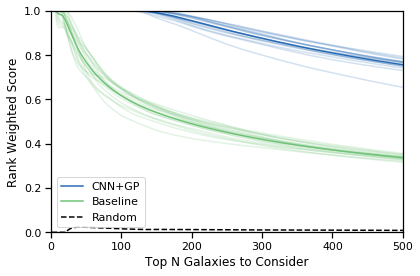

In [58]:
for (experiment, label, color) in [(gz2_gp_rws, 'CNN+GP', 'xkcd:mid blue'), (gz2_forest_rws, 'Baseline', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)

random_labels = gz2_gp_records[0]['labels'].copy()
random.shuffle(random_labels)
random_rws = [shared.get_rank_weighted_score(random_labels, n=n) for n in range(max_to_consider)]
# plt.axhline(gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.plot(random_rws, color='k', linestyle='--', label='Random')

plt.ylim([0., 1.])
plt.legend()
plt.ylabel('Rank Weighted Score')
plt.xlabel('Top N Galaxies to Consider')
# plt.xlim([0., max_to_consider])
plt.xlim([0., 500])
plt.tight_layout()
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.pdf')
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.png')

CNN+GP accuracy at 50: 1.0  at 200:  0.8743333333333333
Baseline accuracy at 50: 0.6573333333333333  at 200:  0.4003333333333334


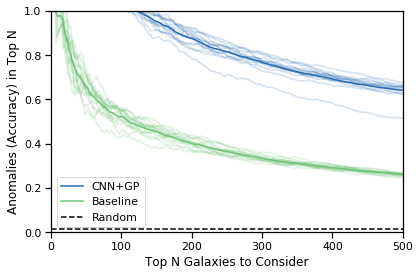

In [60]:
for (experiment, label, color) in [(gz2_gp_precisions, 'CNN+GP', 'xkcd:mid blue'), (gz2_forest_precisions, 'Baseline', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)
        print(label, 'accuracy at 50:', mean_scores[50], ' at 200: ', mean_scores[200])
plt.axhline(gz2_gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.xlabel('Top N Galaxies to Consider')
plt.ylabel('Anomalies (Accuracy) in Top N')
plt.legend()
plt.ylim([0., 1.])
plt.xlim([0., 500])
plt.tight_layout()
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_acc.pdf')
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_acc.png')

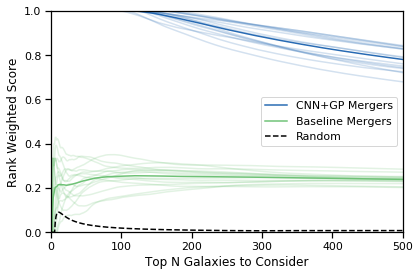

In [68]:
for (experiment, label, color) in [(decals_mergers_gp_rws, 'CNN+GP Mergers', 'xkcd:mid blue'), (decals_mergers_forest_rws, 'Baseline Mergers', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)

random_labels = decals_mergers_gp_records[0]['labels'].copy()
random.shuffle(random_labels)
random_rws = [shared.get_rank_weighted_score(random_labels, n=n) for n in range(max_to_consider)]
# plt.axhline(gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.plot(random_rws, color='k', linestyle='--', label='Random')

plt.ylim([0., 1.])
plt.legend()
plt.ylabel('Rank Weighted Score')
plt.xlabel('Top N Galaxies to Consider')
# plt.xlim([0., max_to_consider])
plt.xlim([0., 500])
plt.tight_layout()
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.pdf')
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.png')

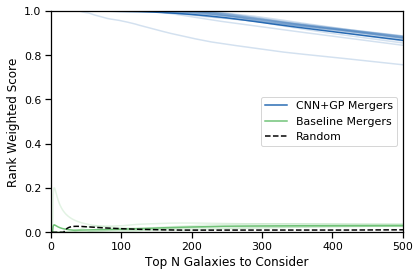

In [69]:
for (experiment, label, color) in [(decals_ring_responses_gp_rws, 'CNN+GP Rings', 'xkcd:mid blue'), (decals_ring_responses_forest_rws, 'Baseline Mergers', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)

random_labels = decals_ring_responses_gp_records[0]['labels'].copy()
random.shuffle(random_labels)
random_rws = [shared.get_rank_weighted_score(random_labels, n=n) for n in range(max_to_consider)]
# plt.axhline(gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.plot(random_rws, color='k', linestyle='--', label='Random')

plt.ylim([0., 1.])
plt.legend()
plt.ylabel('Rank Weighted Score')
plt.xlabel('Top N Galaxies to Consider')
# plt.xlim([0., max_to_consider])
plt.xlim([0., 500])
plt.tight_layout()
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.pdf')
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.png')

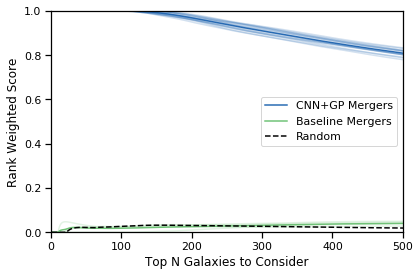

In [70]:
for (experiment, label, color) in [(decals_irreg_gp_rws, 'CNN+GP Irreg.', 'xkcd:mid blue'), (decals_irreg_forest_rws, 'Baseline Mergers', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)

random_labels = decals_irreg_gp_records[0]['labels'].copy()
random.shuffle(random_labels)
random_rws = [shared.get_rank_weighted_score(random_labels, n=n) for n in range(max_to_consider)]
# plt.axhline(gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.plot(random_rws, color='k', linestyle='--', label='Random')

plt.ylim([0., 1.])
plt.legend()
plt.ylabel('Rank Weighted Score')
plt.xlabel('Top N Galaxies to Consider')
# plt.xlim([0., max_to_consider])
plt.xlim([0., 500])
plt.tight_layout()
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.pdf')
# plt.savefig('/home/walml/repos/morphology-tools/notebooks/gz2_rws.png')

In [61]:
for (experiment, label, color) in [(gz2_gp_precisions, 'CNN+GP', 'xkcd:mid blue'), (gz2_forest_precisions, 'Baseline', 'xkcd:soft green')]:
    for n in (50, 200):
        print('{} {} mean {:.3f} 3x std {:.3f}'.format(label, n, np.array(experiment)[:, n].mean(), 3* np.array(experiment)[:, n].std()))

CNN+GP 50 mean 1.000 3x std 0.000
CNN+GP 200 mean 0.874 3x std 0.113
Baseline 50 mean 0.657 3x std 0.159
Baseline 200 mean 0.400 3x std 0.065


In [71]:
for (experiment, label, color) in [(decals_mergers_gp_precisions, 'merger CNN+GP', 'xkcd:mid blue'), (decals_mergers_forest_precisions, 'merger Baseline', 'xkcd:soft green')]:
    for n in (50, 200):
        print('{} {} mean {:.3f} 3x std {:.3f}'.format(label, n, np.array(experiment)[:, n].mean(), 3* np.array(experiment)[:, n].std()))

merger CNN+GP 50 mean 1.000 3x std 0.000
merger CNN+GP 200 mean 0.880 3x std 0.154
merger Baseline 50 mean 0.252 3x std 0.186
merger Baseline 200 mean 0.249 3x std 0.077


In [72]:
for (experiment, label, color) in [(decals_ring_responses_gp_precisions, 'ring_responses CNN+GP', 'xkcd:mid blue'), (decals_ring_responses_forest_precisions, 'ring_responses Baseline', 'xkcd:soft green')]:
    for n in (50, 200):
        print('{} {} mean {:.3f} 3x std {:.3f}'.format(label, n, np.array(experiment)[:, n].mean(), 3* np.array(experiment)[:, n].std()))

ring_responses CNN+GP 50 mean 0.999 3x std 0.015
ring_responses CNN+GP 200 mean 0.958 3x std 0.130
ring_responses Baseline 50 mean 0.010 3x std 0.046
ring_responses Baseline 200 mean 0.033 3x std 0.030


In [73]:
for (experiment, label, color) in [(decals_irreg_gp_precisions, 'irreg CNN+GP', 'xkcd:mid blue'), (decals_irreg_forest_precisions, 'irreg Baseline', 'xkcd:soft green')]:
    for n in (50, 200):
        print('{} {} mean {:.3f} 3x std {:.3f}'.format(label, n, np.array(experiment)[:, n].mean(), 3* np.array(experiment)[:, n].std()))

irreg CNN+GP 50 mean 1.000 3x std 0.000
irreg CNN+GP 200 mean 0.910 3x std 0.054
irreg Baseline 50 mean 0.015 3x std 0.026
irreg Baseline 200 mean 0.033 3x std 0.025
